In [262]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
from matplotlib import pyplot as plt
from IPython.core.debugger import set_trace
import random
from IPython.display import Image
import torchaudio
import librosa
import matplotlib.pyplot as plt
import librosa.display
import glob
import os.path
import IPython
import random
 

In [263]:
# try a dataset, save all spectrograms somewhere
filenames = glob.glob("/home/kchow/datasets/genres/blues/*")
spectrogram_clips = []
mel_spectrogram_clips = []

restart = True

number_of_clips = 100

spec_file = 'spec_clips_sample.npy'

mel_spec_file = 'mel_spec_clips_sample.npy'

duration = 5.0
time_steps = 216

# if numpy loaded 
if not restart and os.path.isfile(spec_file) and os.path.isfile(mel_spec_file):
    spectrogram_clips = np.load(spec_file)
    mel_spectrogram_clips = np.load(mel_spec_file)
else:
    for f in filenames:
        print(f)
        y, sr = librosa.load(f, duration=duration)
        D = np.abs(librosa.stft(y))**2
        print(np.shape(D))
        D = D[:1024,:1939]
        S = librosa.feature.melspectrogram(S=D)
        S = S[:128,:1939]
        if np.shape(D)[0] != 1024 or np.shape(D)[1] != time_steps or np.shape(S)[0] != 128 or np.shape(S)[1] != time_steps:
            continue
        spectrogram_clips.append(D)
        mel_spectrogram_clips.append(S)
        if len(spectrogram_clips) == number_of_clips:
            break

np.save(spec_file, np.array(spectrogram_clips))
np.save(mel_spec_file, np.array(mel_spectrogram_clips))


/home/kchow/datasets/genres/blues/blues.00073.au
(1025, 216)
/home/kchow/datasets/genres/blues/blues.00071.au
(1025, 216)
/home/kchow/datasets/genres/blues/blues.00069.au
(1025, 216)
/home/kchow/datasets/genres/blues/blues.00021.au
(1025, 216)
/home/kchow/datasets/genres/blues/blues.00008.au
(1025, 216)
/home/kchow/datasets/genres/blues/blues.00074.au
(1025, 216)
/home/kchow/datasets/genres/blues/blues.00005.au
(1025, 216)
/home/kchow/datasets/genres/blues/blues.00061.au
(1025, 216)
/home/kchow/datasets/genres/blues/blues.00032.au
(1025, 216)
/home/kchow/datasets/genres/blues/blues.00000.au
(1025, 216)
/home/kchow/datasets/genres/blues/blues.00078.au
(1025, 216)
/home/kchow/datasets/genres/blues/blues.00099.au
(1025, 216)
/home/kchow/datasets/genres/blues/blues.00098.au
(1025, 216)
/home/kchow/datasets/genres/blues/blues.00012.au
(1025, 216)
/home/kchow/datasets/genres/blues/blues.00068.au
(1025, 216)
/home/kchow/datasets/genres/blues/blues.00077.au
(1025, 216)
/home/kchow/datasets/gen

In [264]:
# somethign wrong with snipping? Or when librosa loads need to change it. Or different dataset. 
snip_spectrogram_clips = spectrogram_clips[:]
np.shape(snip_spectrogram_clips)

(100, 1024, 216)

In [265]:
np.sum(snip_spectrogram_clips[0] - snip_spectrogram_clips[3])

8701649.0

In [266]:
# flatten
# standardscalar and whiten
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

snip_spectrogram_clips = np.reshape(snip_spectrogram_clips, (np.shape(snip_spectrogram_clips)[0], time_steps*1024))

scaler = StandardScaler()
snip_spectrogram_clips = scaler.fit_transform(snip_spectrogram_clips)

# no whiten first
"""
pca = PCA(whiten=True)
set_trace()
snip_spectrogram_clips = pca.fit_transform(snip_spectrogram_clips)
"""
# snip_spectrogram_clips = np.reshape(snip_spectrogram_clips, (np.shape(snip_spectrogram_clips)[0], 1024, time_steps))

"""
snip_spectrogram_clips = np.reshape(snip_spectrogram_clips, (len(snip_spectrogram_clips), time_steps*1024))
snip_spectrogram_clips = scaler.inverse_transform(snip_spectrogram_clips)
snip_spectrogram_clips = pca.inverse_transform(snip_spectrogram_clips)
snip_spectrogram_clips = np.reshape(snip_spectrogram_clips, (len(snip_spectrogram_clips), 1024, time_steps))
"""




'\nsnip_spectrogram_clips = np.reshape(snip_spectrogram_clips, (len(snip_spectrogram_clips), time_steps*1024))\nsnip_spectrogram_clips = scaler.inverse_transform(snip_spectrogram_clips)\nsnip_spectrogram_clips = pca.inverse_transform(snip_spectrogram_clips)\nsnip_spectrogram_clips = np.reshape(snip_spectrogram_clips, (len(snip_spectrogram_clips), 1024, time_steps))\n'

In [267]:
np.sum(snip_spectrogram_clips[0] - snip_spectrogram_clips[3])

145806.72

In [268]:
batch_size = 10
epochs = 100
no_cuda = False
seed = 1
beta = 1
log_interval = 1000
cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}
loss_function_type = 'Beta' # [DIP-VAE1, 'DIP-VAE2, Beta']
latent_dimensions = 128
fc_dimensions = 5
print(torch.cuda.current_device())
torch.cuda.set_device(1)
print(torch.cuda.current_device())

1
1


In [269]:
torch.manual_seed
device = torch.device("cuda" if cuda else "cpu")

In [270]:

#time_steps = 200
freq_filters = 1024
channels = 50
k_size = 3
a = 122
b = 94 #1933
# with max pooling new dimensions 
c = 167
d = 32
class MusicSpecAEConv2D(nn.Module):
    def __init__(self):
        super(MusicSpecAEConv2D, self).__init__()
        self.conv1 = nn.Conv2d(1, channels, kernel_size=k_size)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=k_size)
        self.conv3 = nn.Conv2d(channels, channels, kernel_size=k_size)
        
        self.maxpool1 = nn.MaxPool2d((3, 3), return_indices=True)
        self.maxpool2 = nn.MaxPool2d((2, 2), return_indices=True)
        
        # max pool
        # batch norm 
        self.bn1 = nn.BatchNorm2d(channels)
        self.bn2 = nn.BatchNorm2d(channels)
        self.bn3 = nn.BatchNorm2d(channels)
        
        self.bn4 = nn.BatchNorm2d(channels)
        self.bn5 = nn.BatchNorm2d(channels)
        self.bn6 = nn.BatchNorm2d(channels)
        
        # 23 
        
        self.fc1 = nn.Linear(c*d*channels, fc_dimensions)
        self.fc2 = nn.Linear(latent_dimensions, fc_dimensions)
        self.fc3 = nn.Linear(fc_dimensions, c*d*channels)
 
        self.deconv1 = nn.ConvTranspose2d(channels, channels, kernel_size=k_size) #to get same size, just kernel+1
        self.deconv2 = nn.ConvTranspose2d(channels, channels, kernel_size=k_size)
        self.deconv3 = nn.ConvTranspose2d(channels, 1, kernel_size=k_size)
        
        self.maxunpool1 = nn.MaxUnpool2d((2, 2))
        self.maxunpool2 = nn.MaxUnpool2d((3, 3))
        
        self.indicespool1 = None
        self.indicespool2 = None
        
        self.outputsizepool1 = None
        self.outputsizepool2 = None
    
    def encode(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        self.outputsizepool1 = x.size()
        x, self.indicespool1 = self.maxpool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        self.outputsizepool2 = x.size()
        x, self.indicespool2 = self.maxpool2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        #set_trace()
        x = x.view(x.size(0), -1)
        x = F.tanh(self.fc1(x))
        
        return x
    
    def decode(self, z):
        #set_trace()
        z = F.relu(self.fc3(z))
        z = z.view(z.size(0), channels, c, d)
        z = F.relu(self.bn4(self.deconv1(z)))
        z = self.maxunpool1(z, self.indicespool2, output_size = self.outputsizepool2)
        z = F.relu(self.bn5(self.deconv2(z)))
        # size aint right
        z = self.maxunpool2(z, self.indicespool1, output_size = self.outputsizepool1)
        z = F.tanh(self.deconv3(z))
        return z
    
    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)


In [277]:
model = MusicSpecAEConv2D().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
#optimizer = optim.SGD(model.parameters(), lr=1e-3)
average_losses = []

def loss_function(recon_x, x):
    MSE = F.mse_loss(recon_x, x)
    return MSE 

# code from https://stackoverflow.com/questions/8290397/how-to-split-an-iterable-in-constant-size-chunks
def data_batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def train(epoch):
    model.train()
    train_loss = 0
    subset_data = list(snip_spectrogram_clips[:100])
    random.shuffle(subset_data)
    # shuffle subset
    for data in data_batch(subset_data, batch_size):
        # update this to use a larger batch size 
        data = np.array(data)

        data = torch.from_numpy(data)
        data = data.view(data.size(0), 1, freq_filters, time_steps)
        #set_trace()
        data = data.to(device, dtype=torch.float)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = loss_function(recon_batch, data) #/data.size(0)
        loss.backward()
        #use clip here 
        #clip_gradient = 2
        #nn.utils.clip_grad_norm_(model.parameters(), clip_gradient)
        #set_trace()
        train_loss += loss.item()
        optimizer.step()
        print(epoch, loss.item())
    average_loss = train_loss/float(len(subset_data))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, average_loss))#len(mel_spectrogram_clips)))
    average_losses.append(average_loss)

def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    

In [278]:
np.sum(snip_spectrogram_clips[0] - snip_spectrogram_clips[1])

72975.953

1 0.884858906269
1 0.813563406467
1 0.618342280388
1 1.45174813271
1 0.802406847477
1 1.01757454872
1 0.668499648571
1 1.19112169743
1 0.379759907722
1 0.771749079227
====> Epoch: 1 Average loss: 0.0860
2 1.15077257156
2 0.479694277048
2 0.632683753967
2 1.09643280506
2 0.736961781979
2 0.453786879778
2 0.7720900774
2 0.701356589794
2 1.02926743031
2 0.374125570059
====> Epoch: 2 Average loss: 0.0743
3 0.416808396578
3 0.800521612167
3 1.01832592487
3 0.63232499361
3 0.81521743536
3 0.989889442921
3 0.672931373119
3 0.573349893093
3 0.493303775787
3 0.626582860947
====> Epoch: 3 Average loss: 0.0704
4 0.712126612663
4 0.480629593134
4 0.529353678226
4 1.0847107172
4 0.805544734001
4 0.792313396931
4 0.886822521687
4 0.756721913815
4 0.378075748682
4 0.501275718212
====> Epoch: 4 Average loss: 0.0693
5 1.166056633
5 0.80265969038
5 0.647824764252
5 0.656067788601
5 0.663155555725
5 0.698510527611
5 0.357156515121
5 0.537122964859
5 0.711926937103
5 0.573949038982
====> Epoch: 5 Average 

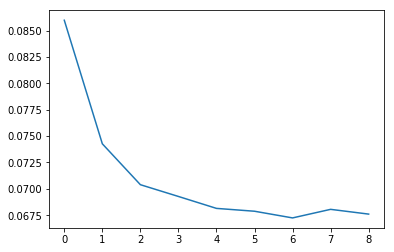

In [279]:
for epoch in range(1, 10):
    train(epoch)
plt.figure(1)
plt.plot(average_losses)
plt.show()

In [280]:
np.sum(snip_spectrogram_clips[0] - snip_spectrogram_clips[1])

72975.953

128563.0


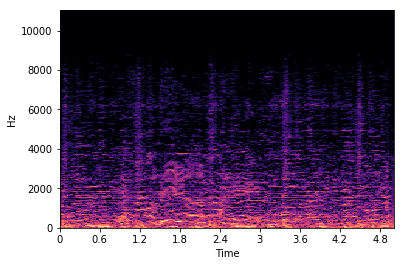

In [282]:
# AE
# reconstruct signal and see how it looks.
# out of memory gucked

# add all boys into samples
sample = snip_spectrogram_clips[:10]
with torch.no_grad():
    print(np.sum(sample[0] - sample[2]))
    sample = torch.from_numpy(sample)
    #sample = torch.transpose(sample, 0, 1)
    sample = sample.contiguous().view(len(sample), 1, freq_filters, time_steps)
    sample = sample.to(device, dtype=torch.float)
    z = model.encode(sample)
    # manipulation here if needed
    # why no change?
    """
    print("Before", z)
    for i in range(z.size()[0]):
        for j in range(fc_dimensions):
            z[i][j] = 1000#10*random.random()
    print("After", z)
    """
    #set_trace()
    sample = model.decode(z).cpu()
sample = np.reshape(sample.numpy(), (len(sample), freq_filters*time_steps))
sample = scaler.inverse_transform(sample)
sample = np.reshape(sample, (len(sample), freq_filters, time_steps))
#set_trace()
# why does it all look the same here? 
test_sample = sample[5]
librosa.display.specshow(librosa.amplitude_to_db(test_sample, ref=np.max), y_axis='linear', x_axis='time')
y_out = librosa.istft(test_sample, length=110122)
IPython.display.Audio(data=y_out, rate=22050)



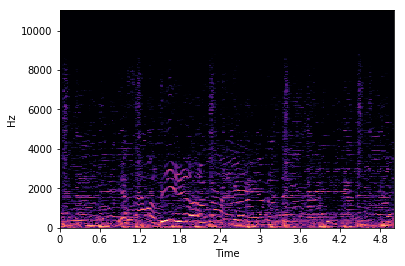

In [261]:
# random latent
with torch.no_grad():
    random_z = torch.randn(10, fc_dimensions).to(device)
    random_sample = model.decode(random_z).cpu()
rs = np.reshape(random_sample.numpy(), (len(random_sample), freq_filters*time_steps))
rs = scaler.inverse_transform(rs)
rs = np.reshape(rs, (len(rs), freq_filters, time_steps))
#set_trace()
# why does it all look the same here? 
test_sample = rs[5]
librosa.display.specshow(librosa.amplitude_to_db(test_sample, ref=np.max), y_axis='linear', x_axis='time')
y_out = librosa.istft(test_sample, length=110122)
IPython.display.Audio(data=y_out, rate=22050)
    

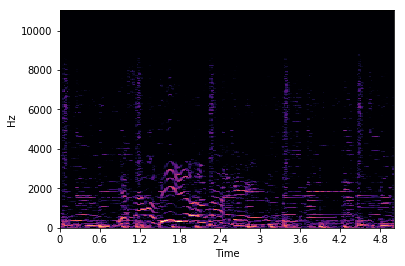

In [283]:
sample_snip = spectrogram_clips[5]
librosa.display.specshow(librosa.amplitude_to_db(sample_snip, ref=np.max), y_axis='linear', x_axis='time')
y_out = librosa.istft(sample_snip, length=110122)
IPython.display.Audio(data=y_out, rate=22050)

In [11]:
# getting stuck and not changing wtf. For some reason getting fucked with 100 time steps. No idea why.
sample_snip = snip_spectrogram_clips[500]
librosa.display.specshow(librosa.amplitude_to_db(sample_snip, ref=np.max), y_axis='linear', x_axis='time')
y_out = librosa.istft(sample_snip, length=50122)
IPython.display.Audio(data=y_out, rate=22050)

IndexError: list index out of range

In [ ]:
sum(spectrogram_clips[0] - spectrogram_clips[1])